<a href="https://colab.research.google.com/github/SrulyRosenblat/OReilly-decop-tests/blob/main/visualize_oreilly_public.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Results On O'Reilly Books

*GPT 4o was used for comments and speeding up development time*



## Building the dataset

In [ ]:
#@title Generate paraphrases to a dataset

import pandas as pd
from litellm import completion
import os
from dotenv import load_dotenv
import re
from itertools import permutations
import json
import pandas as pd
import tqdm

load_dotenv()  # take environment variables from .env.


generate_prompt = """
Rewrite this entire text (all sentences with no exception) expressing the same meaning using different words. Aim to keep the rewriting similar in length to the original text. Do it three times. The text to be rewritten is identified as <Example A>.
Format your output as:
Example B: <insert paraphrase B>
Example C: <insert paraphrase C>
Example D: <insert paraphrase D>
-
Example A: {ref_text}""".strip()

def generate_alternatives(snippet,model="openrouter/anthropic/claude-3.5-sonnet"):
    """Generates n - 1 alternatives for a given snippet"""
    prompt = generate_prompt.format(ref_text=snippet)
    response = completion(model, [{"role": "user", "content": prompt}], temperature=0.1)
    pattern = r'Example [A-Z]:'
    text = response.choices[0].message.content

    # Split the text using the pattern while preserving the split segments
    choices = [segment.strip() for segment in re.split(pattern, text) if segment.strip()]
    choices = [snippet.strip()] + choices
    return choices

def remove_brackets(text):
    if text.startswith('<') and text.endswith('>'):
        return text[1:-1]
    else:
        return text

def clean_dataset(df):
    clean_df = df.dropna()
    clean_df = clean_df.reset_index(drop=True)
    clean_df['Example_A'] = clean_df['Example_A'].apply(remove_brackets)
    clean_df['Example_B'] = clean_df['Example_B'].apply(remove_brackets)
    clean_df['Example_C'] = clean_df['Example_C'].apply(remove_brackets)
    clean_df['Example_D'] = clean_df['Example_D'].apply(remove_brackets)
    return clean_df

# Loop through each row to generate alternatives and assign using iloc
for idx in tqdm(range(len(df))):
    # Generate alternatives for each snippet
    row = df.iloc[idx]
    if row['Example_A']:
        # print(idx)
        continue
    alternatives = generate_alternatives(df.iloc[idx]['snippet'])
    if len(alternatives) != 4:
        print(f'broken {idx}')
        continue


    # Assign each alternative to the corresponding column using iloc
    df.iloc[idx, df.columns.get_loc('Example_A')] = alternatives[0]
    df.iloc[idx, df.columns.get_loc('Example_B')] = alternatives[1]
    df.iloc[idx, df.columns.get_loc('Example_C')] = alternatives[2]
    df.iloc[idx, df.columns.get_loc('Example_D')] = alternatives[3]

df = df[~df.eq(False).any(axis=1)]
df = clean_dataset(df)
df['snippet_id'] = range(1, len(df)+1)
df['Answer'] = 'A'
df.to_csv('oreilly_semi_complete_with_alternatives.csv', index=False)


In [ ]:
#@title Generate permutations

# Read the CSV file into a DataFrame
df = pd.read_csv('oreily_semi_complete_with_alternatives.csv')

# Function to generate permutations of answer options and snippets
def generate_permutations(document_df):
    results = []  # List to store permutation results

    # Iterate over each row in the DataFrame
    for _, row in document_df.iterrows():
        # Mappings to convert between number and letter representations of answers
        num_to_letter_mapping = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}
        letter_to_num_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3}

        # Initialize the answer list with zeros and set the correct answer to 1
        answers = [0, 0, 0, 0]
        answers[letter_to_num_mapping[row['Answer']]] = 1

        # Generate all possible permutations of the answers and snippets
        answer_permutations = list(permutations(answers))

        # note: this leads to 24 permutations the series objects are treated as one object and they are rearanged in 24 diferent ways
        snippet_permutations = list(permutations([
            row['Example_A'], row['Example_B'], row['Example_C'], row['Example_D']
        ]))

        # Combine answer and snippet permutations
        for i, (answer_list, snippet_list) in enumerate(zip(answer_permutations, snippet_permutations)):
            # Find the index of the correct answer (marked as 1)
            index = answer_list.index(1)
            snippet = snippet_list[index]

            # Append a dictionary of the current permutation to the results
            results.append({
                **row.to_dict(),
                'Example_A': snippet_list[0],
                'Example_B': snippet_list[1],
                'Example_C': snippet_list[2],
                'Example_D': snippet_list[3],
                'Answer': num_to_letter_mapping[index],
                'Permutation_Number': i + 1
            })

    # Return the results as a new DataFrame
    return pd.DataFrame(results)

# Generate the permutations and update the DataFrame
df = generate_permutations(df)

# Rename columns to have consistent naming
df = df.rename(columns={
    'date_published': 'Date_Published',
    'title': 'Title',
    'status': 'Status',
    'snippet': 'Snippet',
    'snippet_id': 'Snippet_ID'
})

# Reorder columns to a specific format
new_order = [
    'Snippet_ID', 'Permutation_Number', 'Date_Published', 'Title',
    'Status', 'Snippet', 'Answer', 'Example_A', 'Example_B',
    'Example_C', 'Example_D'
]
df = df[new_order]

# Display the final DataFrame
df


In [ ]:
#@title Build the quizes to be fed into batches
def build_question(row, model):
    extra_prompt = f"""Question: Which of the following passages is verbatim from the \"{row['Title']}\" book?\nOptions:\n"""
    prompt = extra_prompt + 'A. ' + row['Example_A'] + '\n' + 'B. ' + row['Example_B'] + '\n' + 'C. ' + row['Example_C'] + '\n' + 'D. ' + row['Example_D'] + '\n' + 'Answer: '

    return {"custom_id": f"{model}|{row['Snippet_ID']}.{row['Permutation_Number']}", "method": "POST", "url": "/v1/chat/completions",'body':{"model": model, "messages": [
                {"role": "system", "content": "You are a helpful assistant. You must answer using only the provided options A, B, C or D, you may not decline to answer."},
                {"role": "user", "content": prompt}
            ],
            "max_tokens":1,
            "temperature":0,
            "seed": 2319,
            "logprobs":True,
            # this is to make A,B,C and D more likely
            "logit_bias":{32:+100, 33:+100, 34:+100, 35:+100},
            "top_logprobs":20}}

In [ ]:
q= build_question(df.iloc[14545], 'model')
print(q['body']['messages'][1]['content'])

In [ ]:
#@title Startup batches for quizes

client = OpenAI()

models = ['gpt-4o-2024-08-06','gpt-3.5-turbo-0125','gpt-4o']
batches = []
for model in models:
    results = []
    for _,row in df.iterrows():
        results.append(build_question(row, model))
        # build_question(row, model)
    with open(f'batches/{model}.jsonl', 'w') as f:
        for result in results:
            f.write(json.dumps(result) + '\n')

    batch_input_file = client.files.create(
        file=open(f'batches/{model}.jsonl', "rb"),
        purpose="batch",
    )
    batch_input_file_id = batch_input_file.id
    batch_input_file_id = batch_input_file.id

    created_batch = client.batches.create(
        input_file_id=batch_input_file_id,
        endpoint="/v1/chat/completions",
        completion_window="24h",
        metadata={"model": model,"project":'Oreilly_Decop_Test'},

    )
    batches.append(created_batch)

with open('batches.txt', 'w') as f:
    for batch in batches:
        f.write(f'{batch.id}\n')


In [ ]:
#@title Check on batches status

with open('batches.txt', 'r') as f:
    lines = f.readlines()
    for line in lines:
        batch = client.batches.retrieve(line.strip())
        print(batch)


At this point the batches were downloaded and renamed using a GUI

In [ ]:
#@title Calculate the probabilities of each of the 4 options and calculate adjusted probs

from pathlib import Path
from torch import tensor, nn
import torch
import pandas as pd
import json

softmax = nn.Softmax(dim=0)

def get_probs(row):
    import json
    body = row['response']['body']
    model = body['model']
    logprobs = body['choices'][0]['logprobs']['content'][0]['top_logprobs']
    prob_dict = {prob['token']: prob['logprob'] for prob in logprobs}

    # Assign -inf to missing tokens and track missing logprobs
    missing_logprobs = []
    A = prob_dict.get('A', -float('inf'))
    if A == -float('inf'):
        missing_logprobs.append('A')
    B = prob_dict.get('B', -float('inf'))
    if B == -float('inf'):
        missing_logprobs.append('B')
    C = prob_dict.get('C', -float('inf'))
    if C == -float('inf'):
        missing_logprobs.append('C')
    D = prob_dict.get('D', -float('inf'))
    if D == -float('inf'):
        missing_logprobs.append('D')

    # Compute probabilities via softmax
    logprobs_tensor = torch.tensor([A, B, C, D])
    probs = softmax(logprobs_tensor)
    A_prob, B_prob, C_prob, D_prob = probs.tolist()

    variables = {'A': A_prob, 'B': B_prob, 'C': C_prob, 'D': D_prob}
    choice = max(variables, key=variables.get)

    return {
        'Model': model,
        'Logprobs': json.dumps(prob_dict),
        'Prob_A': A_prob,
        'Prob_B': B_prob,
        'Prob_C': C_prob,
        'Prob_D': D_prob,
        'Guessed_Answer_No_Adjustments': choice,
        'Missing_Logprobs': missing_logprobs
    }

def get_file_paths(folder_path):
    folder_path = Path(folder_path)
    return [file_path for file_path in folder_path.rglob('*') if file_path.is_file()]

def calculate_label_adjustment(books, target=0.25):
    """
    Calculates the label adjustments (Δ) based on the DE-COP Logit Calibration Algorithm.
    """
    books = books[['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']]
    # Calculate the average observed probability for each label across all rows
    avg_probabilities = books.mean()

    # Initialize a dictionary to store adjustments for each label
    label_adjustments = {}

    # Calculate the adjustment Δ for each label
    for label in avg_probabilities.index:
        adjustment = target - avg_probabilities[label]
        label_adjustments[label] = adjustment

    return label_adjustments

def adjust_probabilities(probabilities, label_adjustments):
    """
    Adjusts the probability values for each label based on the label adjustments.
    """
    probabilities = probabilities.copy()
    for label, adjustment in label_adjustments.items():
        probabilities[label] = probabilities[label] + adjustment
        probabilities[label] = probabilities[label].clip(0, None)  # Ensure probabilities are non-negative

    # Normalize probabilities so that they sum to 1 for each row
    prob_sum = probabilities[['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']].sum(axis=1)
    probabilities[['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']] = probabilities[['Prob_A', 'Prob_B', 'Prob_C', 'Prob_D']].div(prob_sum, axis=0)

    # Rename columns for adjusted probabilities
    probabilities.rename(columns={
        'Prob_A': 'Adjusted_Prob_A',
        'Prob_B': 'Adjusted_Prob_B',
        'Prob_C': 'Adjusted_Prob_C',
        'Prob_D': 'Adjusted_Prob_D'
    }, inplace=True)

    probabilities = probabilities[['Adjusted_Prob_A', 'Adjusted_Prob_B', 'Adjusted_Prob_C', 'Adjusted_Prob_D']]
    # probabilities['Guessed_Answer'] =
    columns = probabilities.columns
    probabilities['Guessed_Answer'] = probabilities[columns].idxmax(axis=1)
    probabilities['Guessed_Answer'] = probabilities['Guessed_Answer'].apply(lambda x: x.split('_')[-1])


    return probabilities

books_for_calibration = ['Prompt Engineering for Generative AI', 'Web API Cookbook']

for file_path in get_file_paths('./results'):
    df = pd.read_csv('permutations_of_oreilly.csv')
    results = pd.read_json(file_path, lines=True)

    probs = pd.DataFrame(results.apply(get_probs, axis=1).tolist())

    results_with_probs = pd.concat([df, probs], axis=1)

    adjustments = calculate_label_adjustment(results_with_probs[results_with_probs['Title'].isin(books_for_calibration)])
    print(adjustments)
    adjusted_probs = adjust_probabilities(probs, adjustments)
    results_with_probs = pd.concat([results_with_probs, adjusted_probs], axis=1)

    results_with_probs.to_csv('datasets/' + str(file_path).split('/')[-1].replace('.jsonl', '.csv'), index=False)


## Analysing the data


## Initial setup for analysing data


In [1]:
#@title imports

import pandas as pd
from sklearn.metrics import roc_auc_score,roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import numpy as np
from tqdm import tqdm
from joblib import Parallel, delayed
import random

In [4]:
#@title Set up model class and instencess

class Model:
  def __init__(self,model_name ,file_name, cutoff_date, color='blue'):
    self.name = model_name
    self.df =pd.read_csv(file_name)
    self.df['Missing_Logprobs'] = self.df['Missing_Logprobs'].apply(eval)
    self.df['Date_Published'] = pd.to_datetime(self.df['Date_Published'])
    self.cutoff_date = pd.to_datetime([cutoff_date])[0]
    self.color = color

gpt4o = Model('GPT 4o', '4o_output.csv','2023-10-01','teal')# 10/1/2023
gpt4o_mini = Model('GPT 4o Mini', '4o_mini_output.csv','2023-10-01','darkblue')
gpt_turbo = Model('GPT 3.5 Turbo', '35_turbo_output.csv','2021-09-01','purple')# 9/1/2021


## Results based on year *published*

In [5]:
#@title Preform the bulk of calulations
%%capture

import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, roc_auc_score, auc
import random

def calculate_optimal_accuracy(labels, scores):
    # Get all unique threshold values
    thresholds = np.unique(scores)
    accuracies = []

    # Calculate accuracy for each threshold
    for threshold in thresholds:
        predictions = (scores >= threshold).astype(int)
        accuracy = np.mean(predictions == labels)
        accuracies.append(accuracy)

    # Find the maximum accuracy and corresponding threshold
    max_accuracy = max(accuracies)
    optimal_threshold = thresholds[np.argmax(accuracies)]
    return max_accuracy, optimal_threshold

def get_chunk_results(df, chunk_size=24):
    chunks = np.array_split(df, len(df) // chunk_size + 1)
    values = []
    for chunk in chunks:
        correct = sum(chunk['Answer'] == chunk['Guessed_Answer']) / len(chunk)
        values.append({
            'correct': correct,
            'title': chunk.iloc[0]["Title"],
            'status': chunk.iloc[0]['Status'],
            'date': chunk.iloc[0]['Date_Published'],
            'id': chunk.iloc[0]['Snippet_ID']
        })
    values = pd.DataFrame(values)
    return values

# Calculate AUROC by choosing a threshold based on maximizing tpr - fpr
def calculate_auroc_weirdly(book_results):
    scores = book_results['correct_percentage']
    labels = book_results['label']

    # Calculate FPR, TPR, and thresholds
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    # Find the optimal threshold to maximize TPR - FPR
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]

    # Apply the threshold to make binary predictions
    binary_predictions = np.where(scores >= optimal_threshold, 1, 0)

    # Calculate AUROC for binary predictions
    roc_auc = roc_auc_score(labels, binary_predictions)
    return roc_auc

# Calculate balanced AUROC average and optimal accuracy by sampling balanced subsets
def balanced_auroc_average(book_results, chunks, cutoff_date, n=100, seed=42):
    random.seed(seed)
    np.random.seed(seed)

    # Exclude chunks from the cutoff year
    chunks = chunks[chunks['date'].dt.year != cutoff_date.year]

    # Split book results into pre-cutoff and post-cutoff
    pre_cutoff_books = book_results[book_results['label'] == True]
    post_cutoff_books = book_results[book_results['label'] == False]

    # Split chunks into pre-cutoff and post-cutoff
    pre_cutoff_chunks = chunks[chunks['date'].dt.year < cutoff_date.year]
    post_cutoff_chunks = chunks[chunks['date'].dt.year >= cutoff_date.year]

    # Determine the minimum count for balanced sampling at book level
    min_count_books = min(len(pre_cutoff_books), len(post_cutoff_books))

    # Determine the minimum count for balanced sampling at chunk level
    min_count_chunks = min(len(pre_cutoff_chunks), len(post_cutoff_chunks))

    # Initialize lists to store AUROC scores and optimal accuracies
    auroc_book_level_binary_list = []
    auroc_book_level_list = []
    auroc_chunk_level_list = []
    optimal_accuracy_book_list = []
    optimal_threshold_book_list = []
    optimal_accuracy_chunk_list = []
    optimal_threshold_chunk_list = []

    for _ in range(n):
        # Sample indices for balanced book-level samples
        sampled_indices_books_pre = random.sample(list(pre_cutoff_books.index), min_count_books)
        sampled_indices_books_post = random.sample(list(post_cutoff_books.index), min_count_books)

        # Create balanced book-level sample
        sample_pre_books = pre_cutoff_books.loc[sampled_indices_books_pre]
        sample_post_books = post_cutoff_books.loc[sampled_indices_books_post]
        balanced_sample_books = pd.concat([sample_pre_books, sample_post_books])

        # Compute AUROC for book-level sample
        auroc_book_level_binary = calculate_auroc_weirdly(balanced_sample_books)
        auroc_book_level = roc_auc_score(balanced_sample_books['label'], balanced_sample_books['correct_percentage'])

        # Compute optimal accuracy and threshold for book-level sample
        labels_books = balanced_sample_books['label']
        scores_books = balanced_sample_books['correct_percentage']
        optimal_accuracy_book, optimal_threshold_book = calculate_optimal_accuracy(labels_books, scores_books)

        # Store results
        auroc_book_level_binary_list.append(auroc_book_level_binary)
        auroc_book_level_list.append(auroc_book_level)
        optimal_accuracy_book_list.append(optimal_accuracy_book)
        optimal_threshold_book_list.append(optimal_threshold_book)

        # Sample indices for balanced chunk-level samples
        sampled_indices_chunks_pre = random.sample(list(pre_cutoff_chunks.index), min_count_chunks)
        sampled_indices_chunks_post = random.sample(list(post_cutoff_chunks.index), min_count_chunks)

        # Create balanced chunk-level sample
        sample_pre_chunks = pre_cutoff_chunks.loc[sampled_indices_chunks_pre]
        sample_post_chunks = post_cutoff_chunks.loc[sampled_indices_chunks_post]
        balanced_sample_chunks = pd.concat([sample_pre_chunks, sample_post_chunks])

        # Compute AUROC for chunk-level sample
        labels_chunks = balanced_sample_chunks['date'].dt.year < cutoff_date.year
        scores_chunks = balanced_sample_chunks['correct']
        auroc_chunk_level = roc_auc_score(labels_chunks, scores_chunks)

        # Compute optimal accuracy and threshold for chunk-level sample
        optimal_accuracy_chunk, optimal_threshold_chunk = calculate_optimal_accuracy(labels_chunks.astype(int), scores_chunks)

        # Store results
        auroc_chunk_level_list.append(auroc_chunk_level)
        optimal_accuracy_chunk_list.append(optimal_accuracy_chunk)
        optimal_threshold_chunk_list.append(optimal_threshold_chunk)

    # Calculate mean AUROC values and optimal accuracies for the sampled combinations
    return {
        'mean_auroc_book_level_binary': np.mean(auroc_book_level_binary_list),
        'mean_auroc_book_level': np.mean(auroc_book_level_list),
        'mean_auroc_chunk_level': np.mean(auroc_chunk_level_list),
        'mean_optimal_accuracy_book': np.mean(optimal_accuracy_book_list),
        'mean_optimal_threshold_book': np.mean(optimal_threshold_book_list),
        'mean_optimal_accuracy_chunk': np.mean(optimal_accuracy_chunk_list),
        'mean_optimal_threshold_chunk': np.mean(optimal_threshold_chunk_list),
        'sampled_combinations': n
    }
def consistant_dates_average(start_date,end_date,df):
      filtered_df = df[(df['date'] < start_date) | (df['date'] > end_date)]

      labels = filtered_df['date'].apply(lambda x: x.year <= start_date.year)
      scores = filtered_df['correct']
      published_before = []
      published_after = []
      for label, score in zip(labels, scores):
          if label:
              published_before.append(score)
          else:
              published_after.append(score)
      return np.mean(published_before),np.mean(published_after)


# Iterate over models and calculate AUROC metrics
results = []
books_for_calibration = ['Prompt Engineering for Generative AI', 'Web API Cookbook']
start_date = gpt_turbo.cutoff_date
end_date = gpt4o.cutoff_date
for model in [gpt4o, gpt4o_mini, gpt_turbo]:
    print(model.name)
    i = 0

    for data_split in ['all', 'public', 'private']:
        df = model.df.copy()

        # Exclude editions from the dataset
        df = df[~df['Title'].str.contains('edition', case=False)]
        # print('model: 'len(df))
        df = df[~df['Title'].isin(books_for_calibration)]
        if data_split != 'all':
            df = df[df['Status'] == data_split]

        # Split books based on publication date relative to cutoff date
        books_published_before_cutoff = df[df['Date_Published'] < model.cutoff_date]['Title'].unique()
        books_published_after_cutoff = df[df['Date_Published'] >= model.cutoff_date]['Title'].unique()

        print(f"{data_split} before cuttoff: {len(df[df['Date_Published'] < model.cutoff_date]) // 24}")
        print(f"{data_split} after cuttoff: {len(df[df['Date_Published'] > model.cutoff_date]) // 24}")

        # Get chunk results and exclude chunks from the cutoff year
        chunks = get_chunk_results(df)
        # print(len(chunks))
        cutoff_date = model.cutoff_date
        chunks = chunks[chunks['date'].dt.year != cutoff_date.year]

        # Prepare book-level results
        book_results = []
        for book_name, book_df in chunks.groupby('title'):
            correct_percentage = book_df['correct'].mean()
            label = book_df['date'].iloc[0].year < cutoff_date.year
            book_results.append({'title': book_name, 'correct_percentage': correct_percentage, 'label': label})
        book_results = pd.DataFrame(book_results)
        published_before_books = book_results[book_results['label'] == True]['correct_percentage']
        published_after_books = book_results[book_results['label'] == False]['correct_percentage']

        suspected_guess_rate_book_level = published_before_books.mean()
        baseline_guess_rate_book_level = published_after_books.mean()


        # Split chunks into pre-cutoff and post-cutoff based on labels
        published_before = []
        published_after = []

        labels = chunks['date'].apply(lambda x: x.year < cutoff_date.year)
        scores = chunks['correct']

        for label, score in zip(labels, scores):
            if label:
                published_before.append(score)

            else:
                published_after.append(score)

        consistant_suspected_guess_rate,consistant_baseline_guess_rate = consistant_dates_average(start_date,end_date,chunks)



        # Append results for the current model
        results.append({
            'model': model.name,
            'datasplit': data_split,
            'auroc_book_level_binary': calculate_auroc_weirdly(book_results),
            'auroc_book_level': roc_auc_score(book_results['label'], book_results['correct_percentage']),
            'auroc_chunk_level': roc_auc_score(labels.astype(int), scores),
            'baseline_guess_rate': np.mean(published_after),
            'suspected_guess_rate': np.mean(published_before),
            'baseline_guess_rate_book_level': baseline_guess_rate_book_level,
            'suspected_guess_rate_book_level': suspected_guess_rate_book_level ,
            'consistant_baseline_guess_rate':consistant_baseline_guess_rate,
            'consistant_suspected_guess_rate':consistant_suspected_guess_rate,
            'books_published_before_cutoff': books_published_before_cutoff,
            'books_published_after_cutoff': books_published_after_cutoff,
            'cutoff_date': model.cutoff_date,
            'books_published_before_cutoff_count': len(books_published_before_cutoff),
            'books_published_after_cutoff_count': len(books_published_after_cutoff),


            **balanced_auroc_average(book_results, chunks, model.cutoff_date)
        })


### The results are highly dependent on how you choose to do auroc
- The way they chose to do it in thier paper is labeled 'auroc_book_level_binary' here it seems like its cheating the metric a bit as auroc is supposed to be threshold independent.

- I ran a test over multiple balenced subsets to make sure the unballenced set wasnt causing to many problems

In [6]:
#@title Save and show results

auroc_results_on_year_published =pd.DataFrame(results)
auroc_results_on_year_published.to_csv('auroc_results_on_year_published.csv')
auroc_results_on_year_published

,model,datasplit,auroc_book_level_binary,auroc_book_level,auroc_chunk_level,baseline_guess_rate,suspected_guess_rate,baseline_guess_rate_book_level,suspected_guess_rate_book_level,consistant_baseline_guess_rate,...,books_published_before_cutoff_count,books_published_after_cutoff_count,mean_auroc_book_level_binary,mean_auroc_book_level,mean_auroc_chunk_level,mean_optimal_accuracy_book,mean_optimal_threshold_book,mean_optimal_accuracy_chunk,mean_optimal_threshold_chunk,sampled_combinations
0,GPT 4o,all,0.847368,0.842105,0.654631,0.831933,0.921758,0.829625,0.919158,0.831933,...,24,8,0.869000,0.858000,0.655350,0.869000,0.885520,0.633634,0.972446,100
1,GPT 4o,public,0.773684,0.778947,0.627507,0.867795,0.937233,0.870373,0.937374,0.867795,...,24,8,0.789000,0.767600,0.627265,0.789000,0.883907,0.614318,0.949402,100
2,GPT 4o,private,0.847368,0.821053,0.664067,0.805493,0.905062,0.798970,0.893995,0.805493,...,24,8,0.849000,0.826400,0.667227,0.849000,0.849318,0.645755,0.951232,100
3,GPT 4o Mini,all,0.668421,0.621053,0.560674,0.603737,0.657277,0.601141,0.642422,0.603737,...,24,8,0.718000,0.657600,0.561122,0.718000,0.588037,0.556392,0.567717,100
4,GPT 4o Mini,public,0.668421,0.610526,0.559452,0.646142,0.697999,0.646499,0.690815,0.646142,...,24,8,0.671000,0.592000,0.560050,0.671000,0.644810,0.563750,0.647156,100
5,GPT 4o Mini,private,0.636842,0.557895,0.554393,0.568943,0.614352,0.565360,0.582183,0.568943,...,24,8,0.674000,0.573200,0.558419,0.674000,0.566035,0.569623,0.435870,100
6,GPT 3.5 Turbo,all,0.609023,0.526316,0.541927,0.451544,0.486172,0.453055,0.464107,0.443997,...,9,23,0.623571,0.517959,0.541906,0.623571,0.484991,0.547186,0.482917,100
7,GPT 3.5 Turbo,public,0.684211,0.669173,0.594405,0.463617,0.527420,0.463980,0.510513,0.481465,...,9,23,0.682143,0.646122,0.592287,0.682143,0.447497,0.599417,0.455199,100
8,GPT 3.5 Turbo,private,0.556391,0.383459,0.481597,0.439894,0.436314,0.442879,0.399354,0.415029,...,9,23,0.560000,0.375918,0.481700,0.560000,0.381248,0.537062,0.555960,100


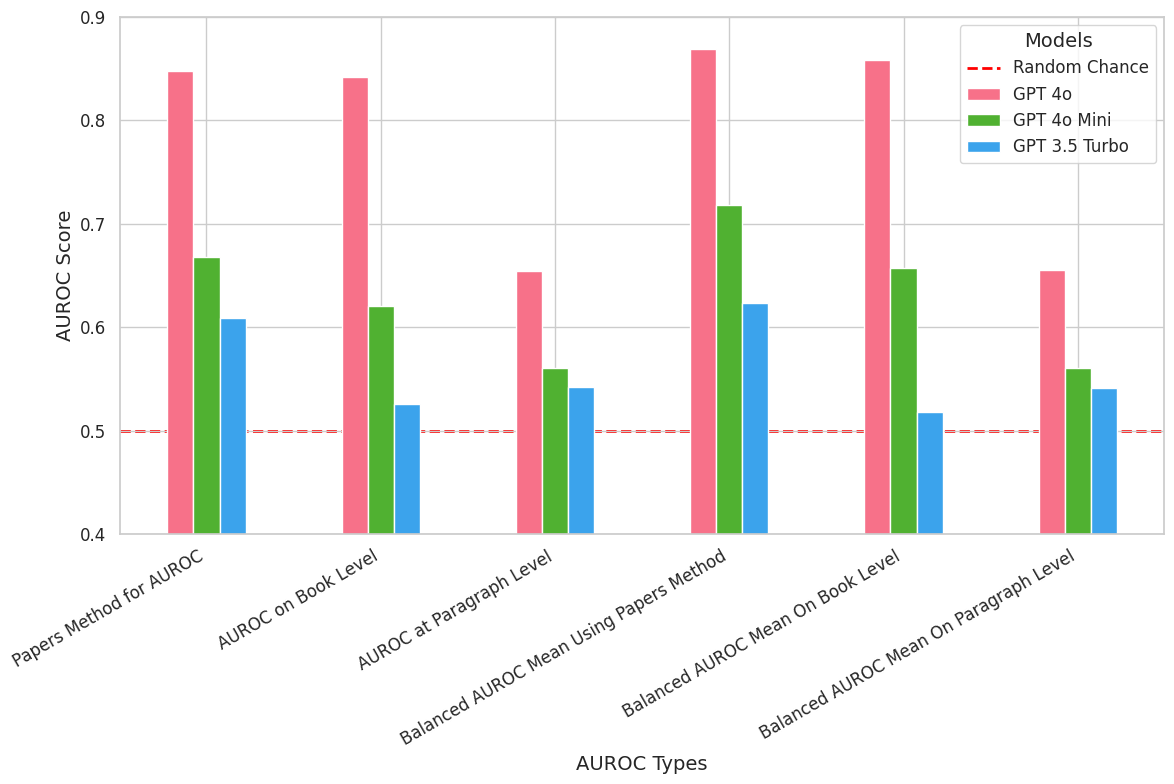

In [7]:
#@title Graph showing big differences in AUROC scores across different ways of calculating AUROC

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Filter the data for 'private' datasplit
df = auroc_results_on_year_published[auroc_results_on_year_published['datasplit'] == 'all'].dropna(
    subset=['auroc_book_level_binary', 'auroc_book_level', 'auroc_chunk_level', 'mean_auroc_book_level_binary', 'mean_auroc_book_level','mean_auroc_chunk_level']
)

# Define models and AUROC score variants
models = df['model']
auroc_book_level_binary = df['auroc_book_level_binary']
auroc_book_level = df['auroc_book_level']
auroc_chunk_level = df['auroc_chunk_level']
mean_auroc_book_level_binary = df['mean_auroc_book_level_binary']
mean_auroc_book_level = df['mean_auroc_book_level']
mean_auroc_chunk_level = df['mean_auroc_chunk_level']

# Define the AUROC types and prepare the data for each model
auroc_types = ['Papers Method for AUROC', 'AUROC on Book Level', 'AUROC at Paragraph Level',
               'Balanced AUROC Mean Using Papers Method', 'Balanced AUROC Mean On Book Level','Balanced AUROC Mean On Paragraph Level']
auroc_data = [auroc_book_level_binary, auroc_book_level, auroc_chunk_level,
              mean_auroc_book_level_binary, mean_auroc_book_level,mean_auroc_chunk_level]

# Check data consistency
if not all(len(x) == len(models) for x in auroc_data):
    raise ValueError("One of the AUROC data lists has a different length than the number of models.")

# Number of models
n_models = len(models)
bar_width = 0.15

# Set a color palette and style for better aesthetics
sns.set(style="whitegrid")
colors = sns.color_palette("husl", n_colors=n_models)

# Plot the improved bar chart
plt.figure(figsize=(12, 8))
plt.ylim(0.4, 0.90)

for i, (model, color) in enumerate(zip(models, colors)):
    plt.bar(np.arange(len(auroc_types)) + i * bar_width,
            [auroc_data[j].iloc[i] for j in range(len(auroc_types))],  # Using .iloc[i] to ensure correct indexing
            bar_width, label=model, color=color)

# Add gridlines, improve font size, and make the chart more aesthetically pleasing
plt.xlabel('AUROC Types', fontsize=14)
plt.ylabel('AUROC Score', fontsize=14)
# plt.title('AUROC Score Comparison by Type for Different Models', fontsize=16)
plt.xticks(np.arange(len(auroc_types)) + (n_models - 1) * bar_width / 2,
           auroc_types, rotation=30, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label="Random Chance", zorder=0)

plt.legend(title='Models', fontsize=12, title_fontsize=14)

# Show the plot with improved layout and readability
plt.tight_layout()
plt.show()


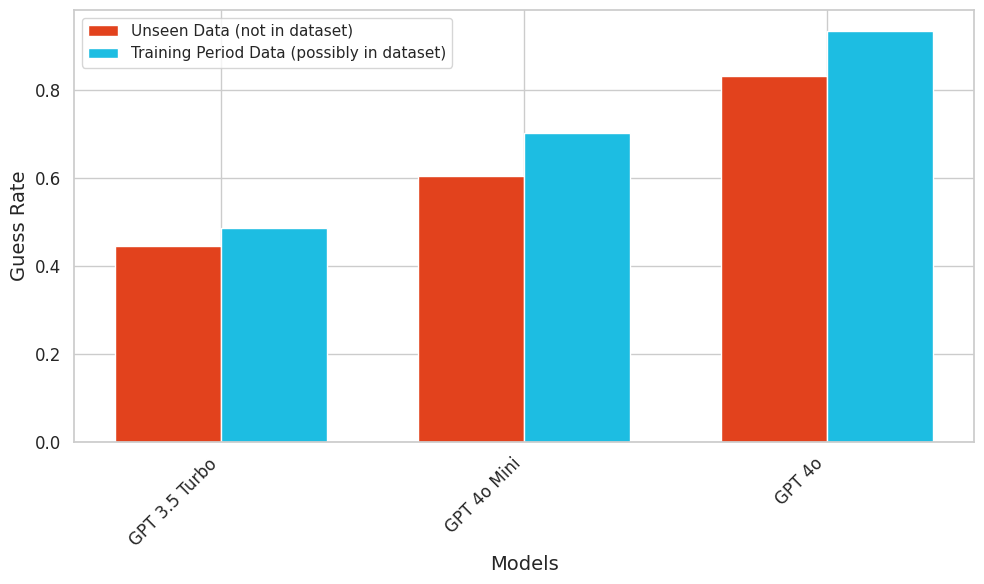

In [8]:
#@title Graph showing how models are getting better at telling real paragraphs from fakes even when not trained on.
models = df['model'][::-1]
suspected_guess_rate = df['consistant_suspected_guess_rate'][::-1]
baseline_guess_rate = df['consistant_baseline_guess_rate'][::-1]

# Define bar properties
bar_width = 0.35
index = np.arange(len(models))

# Set up the plot
plt.figure(figsize=(10, 6))

# Plot baseline guess rate first and suspected guess rate second
plt.bar(index, baseline_guess_rate, bar_width, label='Unseen Data (not in dataset)', color='#E2421D')
plt.bar(index + bar_width, suspected_guess_rate, bar_width, label='Training Period Data (possibly in dataset)', color='#1DBDE2')

# Set plot labels and title
plt.xlabel('Models', fontsize=14)
plt.ylabel('Guess Rate', fontsize=14)
plt.xticks(index + bar_width / 2, models, rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

plt.legend()

# Show the plot with the updated order
plt.tight_layout()
plt.show()


## results on status



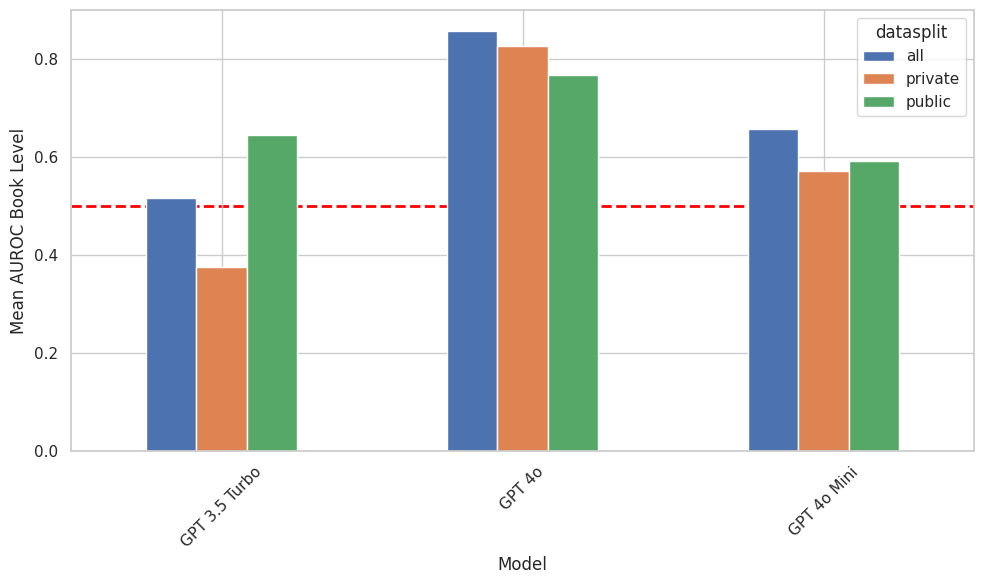

In [9]:
#@title Mean book level AUROC by model, split by availibility status
import matplotlib.pyplot as plt
df = auroc_results_on_year_published
# Filter the necessary columns for the graph
df_filtered = df[['model', 'datasplit', 'mean_auroc_book_level']]

# Create a pivot table to have datasplit on one axis and model on another, with auroc_book_level as values
df_pivot = df_filtered.pivot_table(index='model', columns='datasplit', values='mean_auroc_book_level')


# Plot a grouped bar chart
df_pivot.plot(kind='bar', figsize=(10, 6))
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label="Random Chance", zorder=0)

# Set title and labels
# plt.title('Mean AUROC Comparison Between Different Data Splits Grouped by Model')
plt.ylabel('Mean AUROC Book Level')
plt.xlabel('Model')

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-10-d8166de5ad72>:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_pivot = df_filtered.pivot_table(index='model', columns='datasplit', values='mean_optimal_accuracy_book')


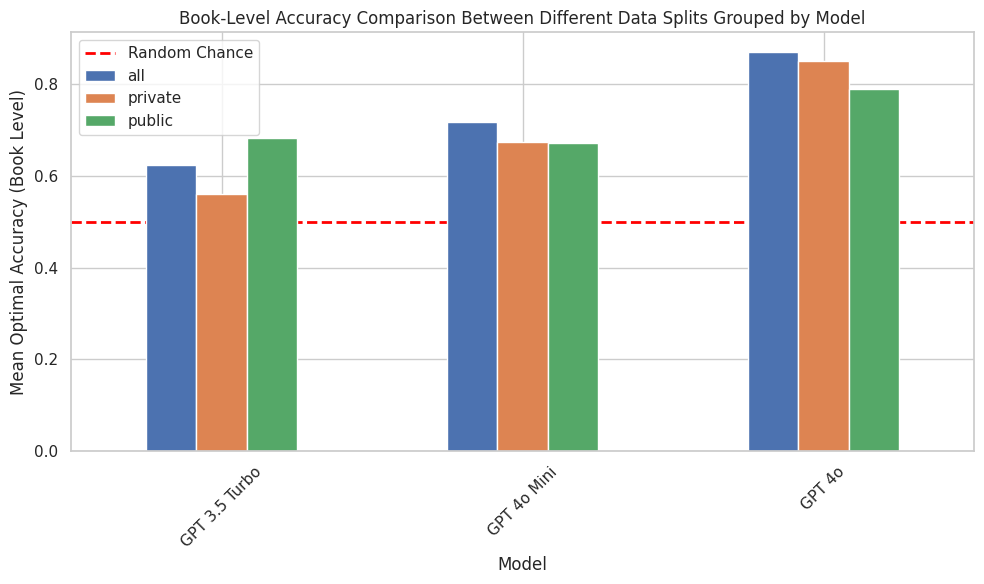

In [10]:
#@title Mean optimal accuraccy by model, split by availibility status
df = auroc_results_on_year_published

# df.sort_values('model',key=lambda x: print(x))
model_order = ['GPT 3.5 Turbo', 'GPT 4o Mini', 'GPT 4o']
df['model'] = pd.Categorical(df['model'], categories=model_order, ordered=True)
# Filter the necessary columns for the graph
df_filtered = df[['model', 'datasplit', 'mean_optimal_accuracy_book']]

# Create a pivot table to have datasplit on one axis and model on another, with mean_optimal_accuracy_book as values
df_pivot = df_filtered.pivot_table(index='model', columns='datasplit', values='mean_optimal_accuracy_book')

# Plot a grouped bar chart
df_pivot.plot(kind='bar', figsize=(10, 6))
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label="Random Chance", zorder=0)

# Set title and labels
plt.title('Book-Level Accuracy Comparison Between Different Data Splits Grouped by Model')
plt.ylabel('Mean Optimal Accuracy (Book Level)')
plt.xlabel('Model')

# Display the plot
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


<ipython-input-11-1751dad022af>:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_pivot = df_filtered.pivot_table(index='model', columns='datasplit', values='mean_optimal_accuracy_book')


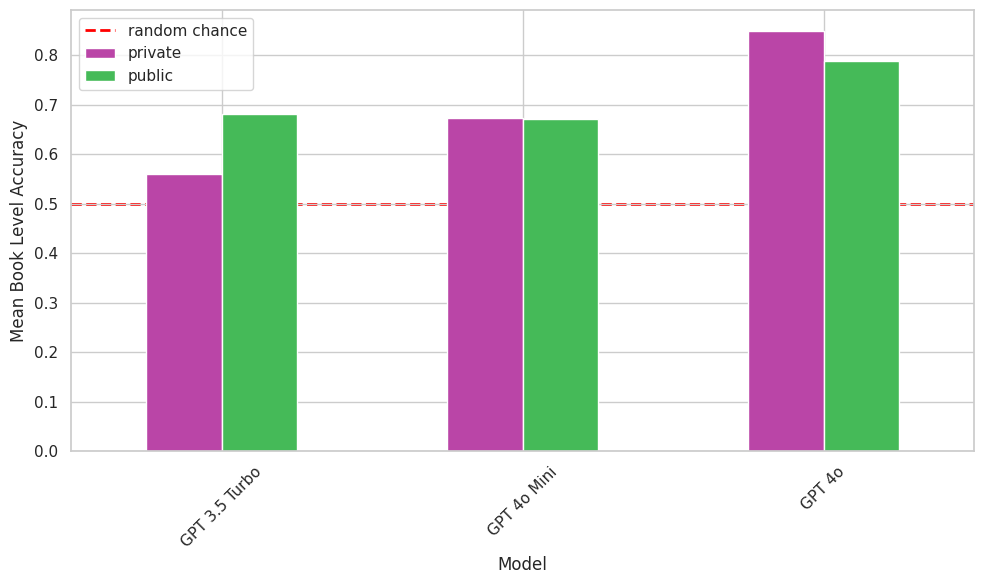

In [11]:
#@title A simplified graph showing Mean optimal accuraccy by model, split by availibility status
df = auroc_results_on_year_published
model_order = ['GPT 3.5 Turbo', 'GPT 4o Mini', 'GPT 4o']
df['model'] = pd.Categorical(df['model'], categories=model_order, ordered=True)

# Filter the necessary columns for the graph
df_filtered = df[['model', 'datasplit', 'mean_optimal_accuracy_book']]

df_filtered = df_filtered[df_filtered['datasplit'] != 'all']
# Create a pivot table to have datasplit on one axis and model on another, with mean_optimal_accuracy_book as values
df_pivot = df_filtered.pivot_table(index='model', columns='datasplit', values='mean_optimal_accuracy_book')

# Plot a grouped bar chart
df_pivot.plot(kind='bar',color=['#BA45A7','#45BA58'], figsize=(10, 6))
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label="random chance", zorder=0)

# Set title and labels
# plt.title('Book-Level Accuracy Comparison Between Different Data Splits Grouped by Model')
plt.ylabel('Mean Book Level Accuracy')
plt.xlabel('Model')

# Display the plot
plt.xticks(rotation=45)
plt.yticks([i * 0.1 for i in range(9)])

plt.legend()
plt.tight_layout()
plt.show()


<ipython-input-12-a942a676ed6f>:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_pivot = df_filtered.pivot_table(index='model', columns='datasplit', values='suspected_guess_rate')


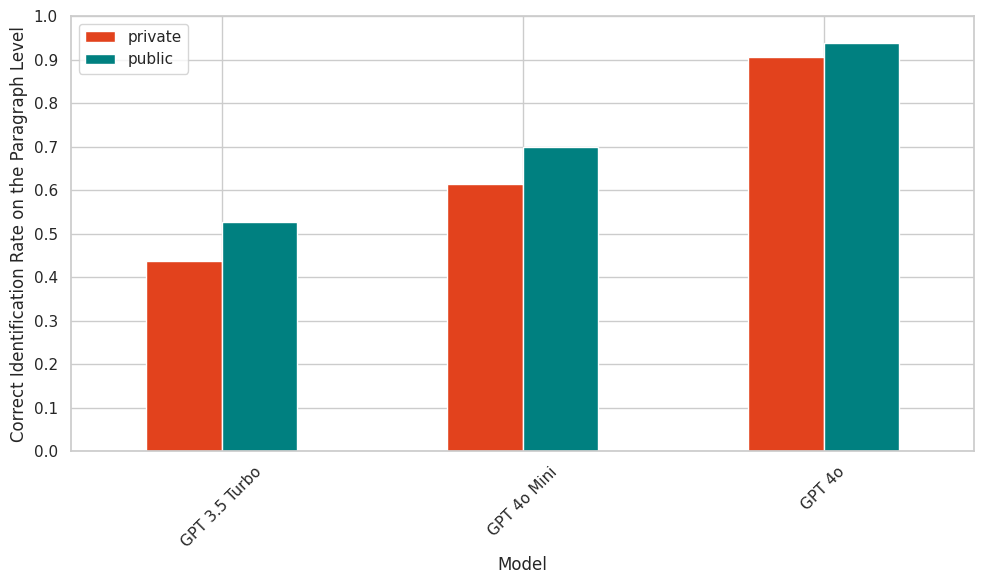

In [12]:
#@title A graph showing how the guess rate changes based on availibility status (paragraph level)
df = auroc_results_on_year_published
model_order = ['GPT 3.5 Turbo', 'GPT 4o Mini', 'GPT 4o']
df['model'] = pd.Categorical(df['model'], categories=model_order, ordered=True)

# Filter the necessary columns for the graph
df_filtered = df[['model', 'datasplit', 'suspected_guess_rate']]

df_filtered = df_filtered[df_filtered['datasplit'] != 'all']
# Create a pivot table to have datasplit on one axis and model on another, with mean_optimal_accuracy_book as values
df_pivot = df_filtered.pivot_table(index='model', columns='datasplit', values='suspected_guess_rate')

# Plot a grouped bar chart
df_pivot.plot(kind='bar',color=['#E2421D','teal'], figsize=(10, 6))
# plt.axhline(y=0.25, color='red', linestyle='--', linewidth=2, label="random chance", zorder=0)
plt.yticks([i * 0.1 for i in range(11)])

# Set title and labels
# plt.title('Book-Level Accuracy Comparison Between Different Data Splits Grouped by Model')
plt.ylabel('Correct Identification Rate on the Paragraph Level')
plt.xlabel('Model')

# Display the plot
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


<ipython-input-13-fff6da11f457>:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_pivot = df_filtered.pivot_table(index='model', columns='datasplit', values='suspected_guess_rate_book_level')


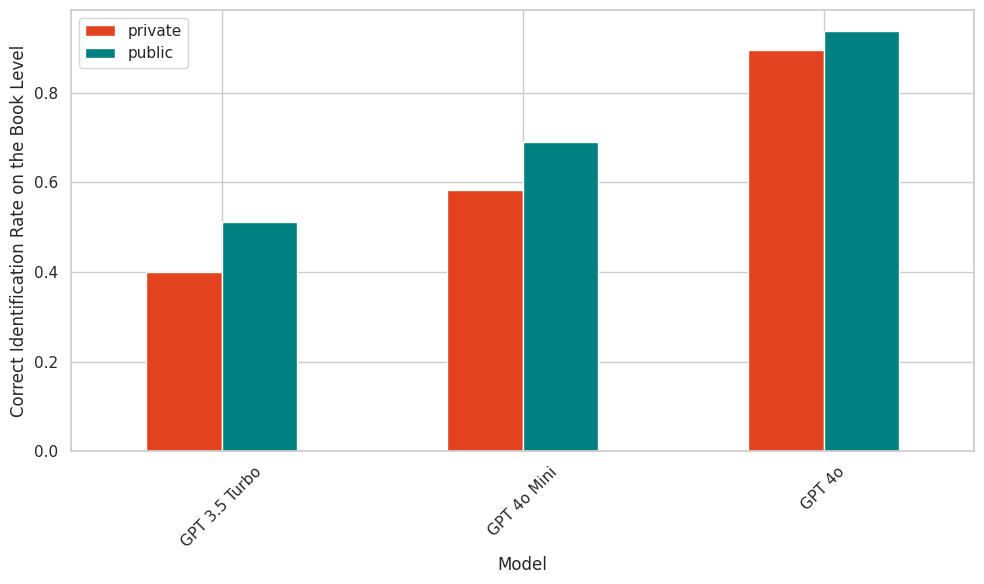

In [13]:
#@title A graph showing how the guess rate changes based on availibility status (book level)
df = auroc_results_on_year_published
model_order = ['GPT 3.5 Turbo', 'GPT 4o Mini', 'GPT 4o']
df['model'] = pd.Categorical(df['model'], categories=model_order, ordered=True)

# Filter the necessary columns for the graph
df_filtered = df[['model', 'datasplit', 'suspected_guess_rate_book_level']]

df_filtered = df_filtered[df_filtered['datasplit'] != 'all']
# Create a pivot table to have datasplit on one axis and model on another, with mean_optimal_accuracy_book as values
df_pivot = df_filtered.pivot_table(index='model', columns='datasplit', values='suspected_guess_rate_book_level')

# Plot a grouped bar chart
df_pivot.plot(kind='bar',color=['#E2421D','teal'], figsize=(10, 6))
# plt.axhline(y=0.25, color='red', linestyle='--', linewidth=2, label="random chance", zorder=0)

# Set title and labels
# plt.title('Book-Level Accuracy Comparison Between Different Data Splits Grouped by Model')
plt.ylabel('Correct Identification Rate on the Book Level')
plt.xlabel('Model')

# Display the plot
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


<ipython-input-14-9f25df627468>:9: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_pivot_chunk = df_filtered_chunk.pivot_table(index='model', columns='datasplit', values='mean_optimal_accuracy_chunk')


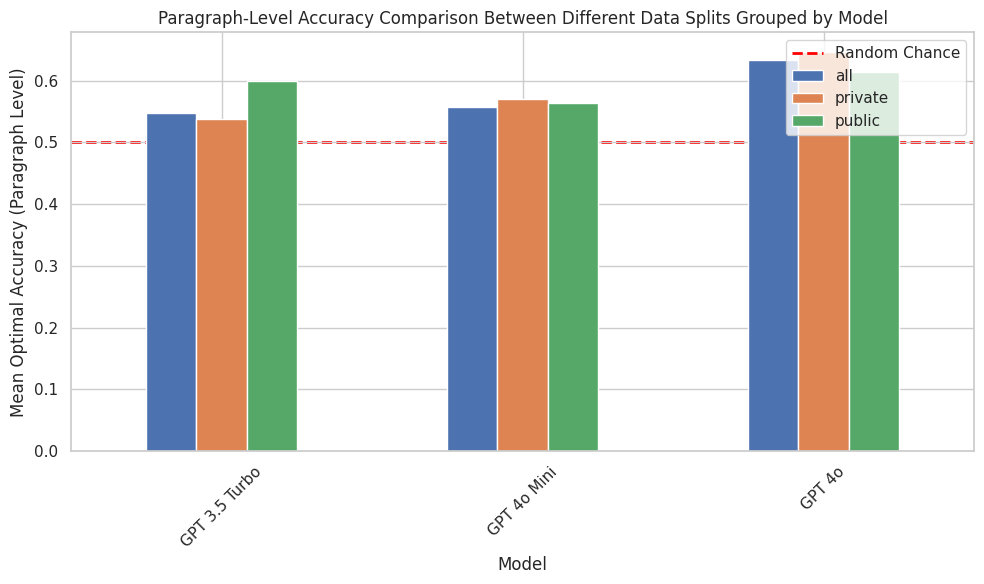

In [14]:
#@title A graph showing how the guess rate changes based on availibility status (book level)

df = auroc_results_on_year_published

# Filter the necessary columns for chunk level accuracy
df_filtered_chunk = df[['model', 'datasplit', 'mean_optimal_accuracy_chunk']]

# Create a pivot table to have datasplit on one axis and model on another, with mean_optimal_accuracy_chunk as values
df_pivot_chunk = df_filtered_chunk.pivot_table(index='model', columns='datasplit', values='mean_optimal_accuracy_chunk')

# Plot a grouped bar chart
df_pivot_chunk.plot(kind='bar', figsize=(10, 6))
plt.axhline(y=0.5, color='red', linestyle='--', linewidth=2, label="Random Chance", zorder=0)

# Set title and labels
plt.title('Paragraph-Level Accuracy Comparison Between Different Data Splits Grouped by Model')
plt.ylabel('Mean Optimal Accuracy (Paragraph Level)')
plt.xlabel('Model')

# Display the plot
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


# Split By Book

In [24]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
import random

import random
import pandas as pd

def generate_splits(df, n=1000,min_samples=2):
    df = df[df['Date_Published'].dt.year != cutoff_date.year]

    # Separate books by cutoff date
    pre_cutoff_books = df[df['Date_Published'] < gpt4o.cutoff_date]['Title'].unique()
    post_cutoff_books = df[df['Date_Published'] > gpt4o.cutoff_date]['Title'].unique()

    # Ensure we can split evenly
    max_books = min(len(pre_cutoff_books), len(post_cutoff_books))


    splits = []
    for _ in range(n):
        num_books_per_split = random.randint(min_samples,max_books )
        # Select random sample of pre- and post-cutoff books
        pre_sample = random.sample(list(pre_cutoff_books), num_books_per_split)
        post_sample = random.sample(list(post_cutoff_books), num_books_per_split)

        # Combine to create split
        splits.append((pre_sample, post_sample))

    return splits

def train_test_split_books(df, ):
    pre_cutoff_books = df[df['Date_Published'] < gpt4o.cutoff_date]['Title'].unique()
    post_cutoff_books = df[df['Date_Published'] > gpt4o.cutoff_date]['Title'].unique()
    post_count = len(post_cutoff_books)
    train = random.sample(list(pre_cutoff_books), post_count)
    train.extend(post_cutoff_books)
    return train, list(set(pre_cutoff_books) - set(train))

# Assuming gpt4o.df is the DataFrame and gpt4o.cutoff_date is the cutoff date
df = gpt4o.df.copy()
seed = 42
random.seed(42)
cutoff_date = gpt4o.cutoff_date
train_set, test_set = train_test_split_books(df)
train = df[df['Title'].isin(train_set)]
test = df[df['Title'].isin(test_set)]

# Add a label column: 0 for pre-cutoff books, 1 for post-cutoff books
train['Label'] = np.where(train['Date_Published'] < cutoff_date, 0, 1)
train = train[train['Status'] == 'private']
# Function to calculate the optimal threshold
def find_optimal_threshold(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

chunks = get_chunk_results(df)
chunks = chunks[chunks['date'].dt.year != cutoff_date.year]
chunks

book_results = []
for book_name, book_df in chunks.groupby('title'):
    correct_percentage = book_df['correct'].mean()
    label = book_df['date'].iloc[0].year < cutoff_date.year
    book_results.append({'title': book_name, 'correct_percentage': correct_percentage, 'label': label})
book_results = pd.DataFrame(book_results)
book_results
thresholds = []
for in_dataset, out_of_dataset in generate_splits(train):
  books = book_results[(book_results['title'].isin(in_dataset)) | (book_results['title'].isin(out_of_dataset))]

  threshold = find_optimal_threshold(books['label'], books['correct_percentage'])
  thresholds.append(threshold)


tested_books = book_results[book_results['title'].isin(test_set)]
tested_books['percentage_of_time_above_threshold'] = tested_books['correct_percentage'].apply(
    lambda cp: np.mean([cp > t for t in thresholds])
)
print(f"Train set size (book count):{len(book_results[book_results['title'].isin(train_set)])}")
print(f"Test set size (book count):{len(book_results[book_results['title'].isin(test_set)])}")

tested_books


<ipython-input-24-e5cc61804a57>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Label'] = np.where(train['Date_Published'] < cutoff_date, 0, 1)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


['Natural Language Processing with Spark NLP', 'Azure Cookbook', 'Distributed Tracing in Practice', 'Communicating with Data', 'DevOps Tools for Java Developers', 'Practical Natural Language Processing', 'C# 8.0 in a Nutshell', 'Learning Digital Identity', 'Programming C# 10', 'AI-Powered Business Intelligence', 'Building Recommendation Systems in Python and JAX', 'Building Green Software', 'FastAPI', 'Deciphering Data Architectures', 'Web Accessibility Cookbook', 'Prompt Engineering for Generative AI', 'Continuous Deployment', 'Policy as Code', 'Delta Lake: Up and Running', 'Web API Cookbook']
Train set size (book count):15
Test set size (book count):11


<ipython-input-24-e5cc61804a57>:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tested_books['percentage_of_time_above_threshold'] = tested_books['correct_percentage'].apply(


,title,correct_percentage,label,percentage_of_time_above_threshold
0,97 Things Every Information Security Professio...,0.949653,True,0.773
2,Advancing into Analytics,0.879386,True,0.012
3,Applied Machine Learning and AI for Engineers,0.875000,True,0.012
6,Cloud Native Go,0.974806,True,0.958
9,Data Quality Fundamentals,0.952140,True,0.773
13,Genomics in the Cloud,0.898148,True,0.012
14,Leading Lean,0.934669,True,0.712
20,RESTful Web API Patterns and Practices Cookbook,0.926535,True,0.712
21,Security and Microservice Architecture on AWS,0.845238,True,0.012
22,Software Architecture: The Hard Parts,0.960563,True,0.773
